Task 1: Data Understanding and Visualization


In [24]:
!pip install Pillow

In [25]:
!pip install matplotlib

In [26]:
!gdown 1pDBeGzlhBiPhhUYj8nSKgm2A-G0ZsQ0A

Downloading...
From: https://drive.google.com/uc?id=1pDBeGzlhBiPhhUYj8nSKgm2A-G0ZsQ0A
To: /content/Copy of FruitinAmazon.zip
100% 1.24M/1.24M [00:00<00:00, 79.3MB/s]


In [27]:
!unzip Copy\ of\ FruitinAmazon.zip

Archive:  Copy of FruitinAmazon.zip
replace FruitinAmazon/test/cupuacu/download (5).jpeg? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [28]:
!pip install gdown

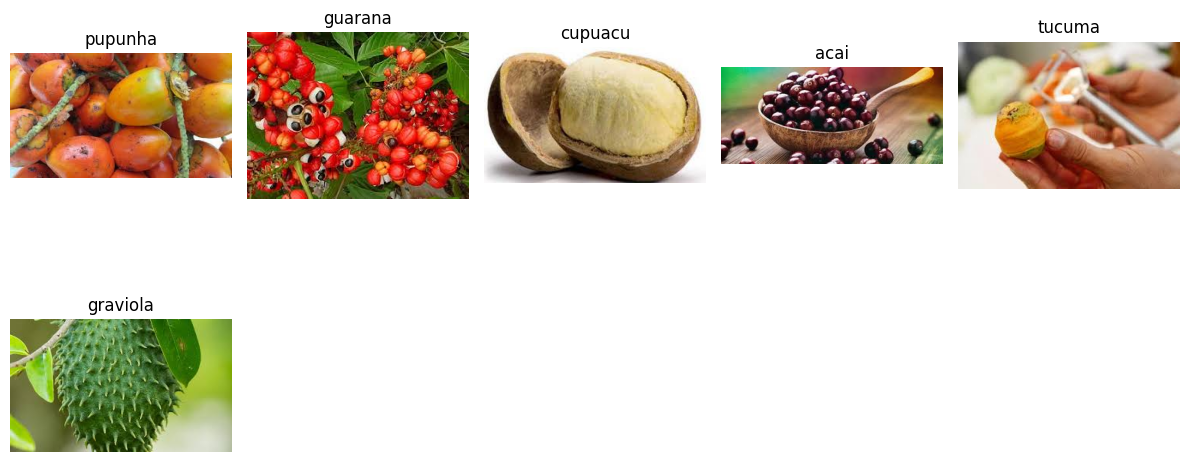

In [29]:
import os
import matplotlib.pyplot as plt
import random
from PIL import Image

# Set your dataset path
train_dir = '/content/FruitinAmazon/train'

# Get class names
class_names = os.listdir(train_dir)

# Display random image from each class
plt.figure(figsize=(12, 6))
for i, fruit_class in enumerate(class_names[:10]):  # limit to 10 classes for visual clarity
    class_path = os.path.join(train_dir, fruit_class)
    img_name = random.choice(os.listdir(class_path))
    img_path = os.path.join(class_path, img_name)
    img = Image.open(img_path)
    plt.subplot(2, 5, i+1)
    plt.imshow(img)
    plt.title(fruit_class)
    plt.axis('off')
plt.tight_layout()
plt.show()

This code displays a random sample image from each fruit class in the Amazon Fruit dataset. It helps us visually understand the dataset structure and image quality.

In [30]:
from PIL import UnidentifiedImageError

corrupted = []

for fruit_class in os.listdir(train_dir):
    class_path = os.path.join(train_dir, fruit_class)
    for img_file in os.listdir(class_path):
        img_path = os.path.join(class_path, img_file)
        try:
            img = Image.open(img_path)
            img.verify()  # verifies integrity
        except (UnidentifiedImageError, IOError, SyntaxError):
            print(f"Removed corrupted image: {img_path}")
            corrupted.append(img_path)
            os.remove(img_path)

if not corrupted:
    print("No corrupted images found.")

No corrupted images found.


In [31]:
class_counts = {}

for class_name in class_names:
    class_path = os.path.join(train_dir, class_name)
    images = [img for img in os.listdir(class_path) if img.lower().endswith(('.jpg', '.png', '.jpeg'))]
    class_counts[class_name] = len(images)

print("\nClass Distribution:")
for k, v in class_counts.items():
    print(f"{k}: {v} images")



Class Distribution:
pupunha: 15 images
guarana: 15 images
cupuacu: 15 images
acai: 15 images
tucuma: 15 images
graviola: 15 images


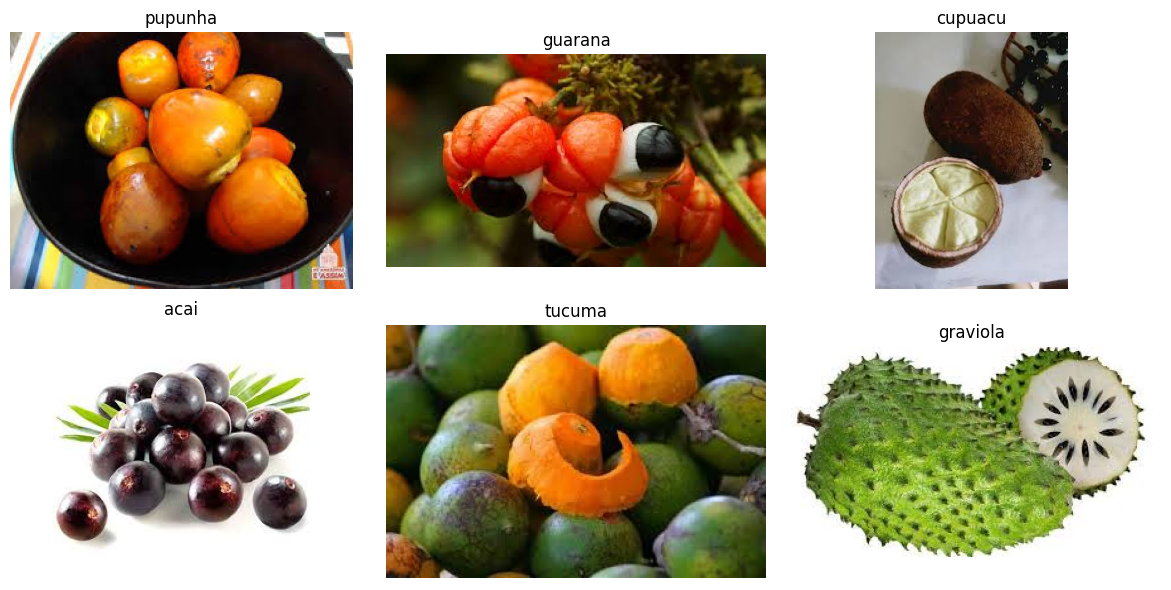

In [32]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random

selected_images = []
selected_labels = []

for class_name in class_names:
    class_path = os.path.join(train_dir, class_name)
    img_name = random.choice(os.listdir(class_path))
    selected_images.append(os.path.join(class_path, img_name))
    selected_labels.append(class_name)

cols = (len(selected_images) + 1) // 2
fig, axes = plt.subplots(2, cols, figsize=(12, 6))

for i, ax in enumerate(axes.flat):
    if i < len(selected_images):
        img = mpimg.imread(selected_images[i])
        ax.imshow(img)
        ax.set_title(selected_labels[i])
        ax.axis('off')
plt.tight_layout()
plt.show()


In [33]:
import tensorflow as tf
from tensorflow.keras import layers

# 1. Define augmentation + rescaling
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
    layers.RandomContrast(0.1),
    layers.Rescaling(1./255)
])

# 2. Load raw datasets
image_size = (224, 224)
batch_size = 32

raw_train_ds = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    validation_split=0.2,
    subset="training",
    seed=42,
    image_size=image_size,
    batch_size=batch_size
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    validation_split=0.2,
    subset="validation",
    seed=42,
    image_size=image_size,
    batch_size=batch_size
)

# 3. Get class names
class_names = raw_train_ds.class_names
num_classes = len(class_names)

# 4. Apply augmentation to train set only
train_ds = raw_train_ds.map(lambda x, y: (data_augmentation(x, training=True), y))

# 5. Apply rescaling only to val set
val_ds = val_ds.map(lambda x, y: (layers.Rescaling(1./255)(x), y))

# ✅ 6. Add caching, shuffling, prefetching
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)


Found 90 files belonging to 6 classes.
Using 72 files for training.
Found 90 files belonging to 6 classes.
Using 18 files for validation.


In [34]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, BatchNormalization, Activation

model = Sequential([
    layers.Input(shape=(224, 224, 3)),

    # Block 1
    Conv2D(32, (3, 3), padding='same', activation=None),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D(),
    Dropout(0.25),

    # Block 2
    Conv2D(64, (3, 3), padding='same', activation=None),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D(),
    Dropout(0.25),

    # Block 3
    Conv2D(128, (3, 3), padding='same', activation=None),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D(),
    Dropout(0.25),

    # Block 4
    Conv2D(256, (3, 3), padding='same', activation=None),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D(),
    Dropout(0.25),

    # Fully Connected Layers
    Flatten(),
    Dense(512), BatchNormalization(), Activation('relu'), Dropout(0.5),
    Dense(256), BatchNormalization(), Activation('relu'), Dropout(0.5),
    Dense(128), BatchNormalization(), Activation('relu'), Dropout(0.5),
    Dense(64), BatchNormalization(), Activation('relu'), Dropout(0.5),
    Dense(len(class_names), activation='softmax')
])

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)               │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 224, 224, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_8 (Activation)       │ (None, 224, 224, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_9 (Activation)       │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_10 (Activation)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 28, 28, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 28, 28, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_11 (Activation)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 14, 14, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 14, 14, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 50176)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 512)            │    25,690,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_12          │ (None, 512)            │         2,04

 Total params: 26,257,670 (100.17 MB)

 Trainable params: 26,254,790 (100.15 MB)

 Non-trainable params: 2,880 (11.25 KB)

In [35]:
from tensorflow.keras import layers

data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
])


In [36]:
# Load unmodified dataset
raw_train_ds = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    validation_split=0.2,
    subset="training",
    seed=42,
    image_size=(224, 224),
    batch_size=8  # Small batch for easier visualization
)

# Get a batch (one batch = 8 images)
for images, labels in raw_train_ds.take(1):
    original_images = images
    augmented_images = data_augmentation(images)


Found 90 files belonging to 6 classes.
Using 72 files for training.


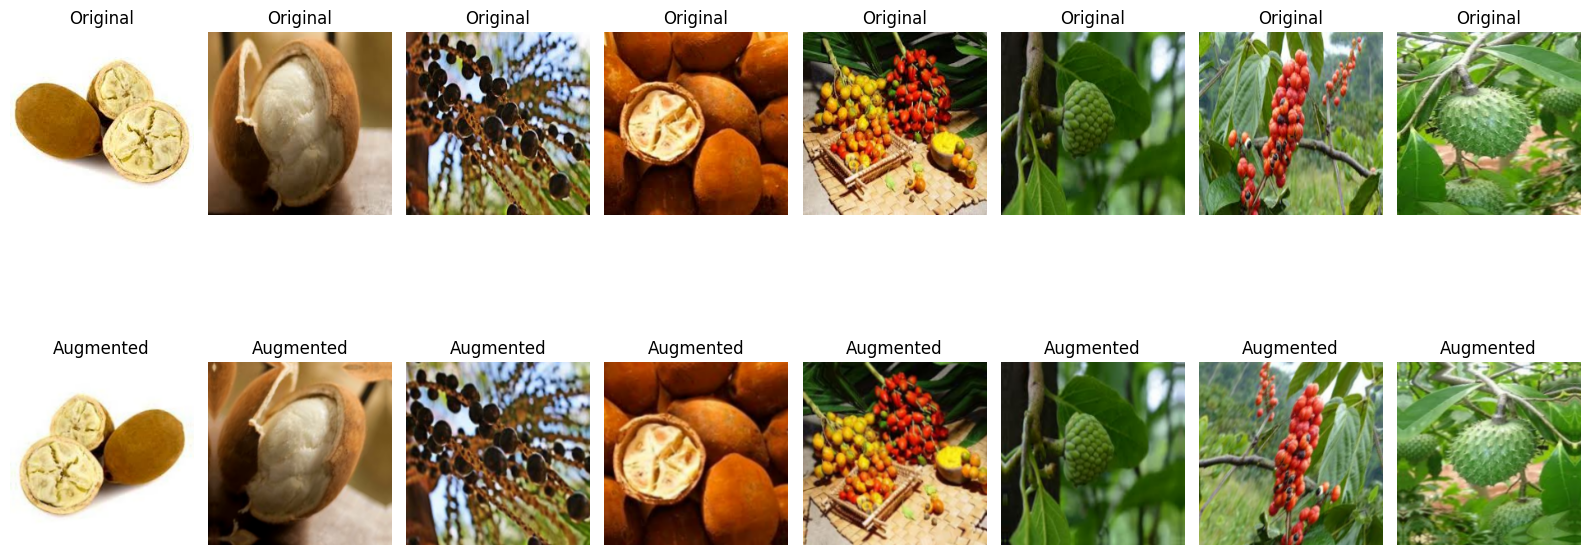

In [37]:
import matplotlib.pyplot as plt

plt.figure(figsize=(16, 8))

for i in range(8):
    # Original image
    plt.subplot(2, 8, i + 1)
    plt.imshow(original_images[i].numpy().astype("uint8"))
    plt.title("Original")
    plt.axis('off')

    # Augmented image
    plt.subplot(2, 8, i + 9)
    plt.imshow(augmented_images[i].numpy().astype("uint8"))
    plt.title("Augmented")
    plt.axis('off')

plt.tight_layout()
plt.show()


In [38]:
history = model.fit(train_ds, validation_data=val_ds, epochs=30)

test_loss, test_acc = model.evaluate(val_ds)
print(f"Test Accuracy: {test_acc:.4f}")


Epoch 1/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 32s 6s/step - accuracy: 0.1445 - loss: 2.5749 - val_accuracy: 0.1667 - val_loss: 1.7856
Epoch 2/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 38s 5s/step - accuracy: 0.1958 - loss: 2.2856 - val_accuracy: 0.1667 - val_loss: 1.8119
Epoch 3/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 18s 6s/step - accuracy: 0.1460 - loss: 2.3130 - val_accuracy: 0.1667 - val_loss: 1.8388
Epoch 4/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 17s 5s/step - accuracy: 0.2470 - loss: 2.1044 - val_accuracy: 0.1667 - val_loss: 1.8567
Epoch 5/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 19s 5s/step - accuracy: 0.2010 - loss: 2.0819 - val_accuracy: 0.1667 - val_loss: 1.8641
Epoch 6/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 18s 8s/step - accuracy: 0.2465 - loss: 1.7013 - val_accuracy: 0.1667 - val_loss: 1.8601
Epoch 7/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 18s 8s/step - accuracy: 0.2208 - loss: 1.9637 - val_accuracy: 0.1667 - val_loss: 1.8553
Epoch 8/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 20s 8s/step - accuracy: 0.2125 - loss: 2.0734 - val_accuracy: 0.1667 - val_loss: 1.8571
Epoch 9/

In [39]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.optimizers import Adam

# STEP 1: Load base model with frozen layers
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False  # Freeze everything initially

# STEP 2: Add custom layers on top
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
output = Dense(len(class_names), activation='softmax')(x)

model_vgg = Model(inputs=base_model.input, outputs=output)

# STEP 3: Compile and train (Phase 1)
model_vgg.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
history = model_vgg.fit(train_ds, validation_data=val_ds, epochs=10)


58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 65s 30s/step - accuracy: 0.1153 - loss: 1.9534 - val_accuracy: 0.3333 - val_loss: 1.8241
Epoch 2/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 64s 22s/step - accuracy: 0.3173 - loss: 1.7012 - val_accuracy: 0.1667 - val_loss: 1.7312
Epoch 3/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 72s 17s/step - accuracy: 0.4470 - loss: 1.4025 - val_accuracy: 0.5000 - val_loss: 1.5503
Epoch 4/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 54s 17s/step - accuracy: 0.6998 - loss: 1.2253 - val_accuracy: 0.5000 - val_loss: 1.5310
Epoch 5/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 65s 22s/step - accuracy: 0.6997 - loss: 1.1099 - val_accuracy: 0.5000 - val_loss: 1.5322
Epoch 6/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 64s 30s/step - accuracy: 0.8125 - loss: 0.8300 - val_accuracy: 0.5000 - val_loss: 1.4704
Epoch 7/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 63s 22s/step - accuracy: 0.8531 - loss: 0.8724 - val_accuracy: 0.5000 - val_loss: 1.3931
Epoch 8/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 54s 17s/step - accuracy: 0.8462 - loss

In [40]:
from sklearn.metrics import classification_report
import numpy as np

# Get true labels
y_true = np.concatenate([y for x, y in val_ds])

# Get predictions
y_pred_probs = model_vgg.predict(val_ds)
y_pred = np.argmax(y_pred_probs, axis=1)

print(classification_report(y_true, y_pred, target_names=class_names))


1/1 ━━━━━━━━━━━━━━━━━━━━ 20s 20s/step
              precision    recall  f1-score   support

        acai       1.00      0.33      0.50         3
     cupuacu       0.50      0.75      0.60         4
    graviola       0.50      1.00      0.67         1
     guarana       0.50      0.67      0.57         3
     pupunha       0.00      0.00      0.00         4
      tucuma       0.40      0.67      0.50         3

    accuracy                           0.50        18
   macro avg       0.48      0.57      0.47        18
weighted avg       0.46      0.50      0.43        18



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
